In [26]:
import cv2
import numpy as np
import os

# Load the image
image_path = './opal6.jpeg'
assert os.path.exists(image_path)

img = cv2.imread(image_path)

In [27]:
import cv2
from matplotlib import pyplot as plt

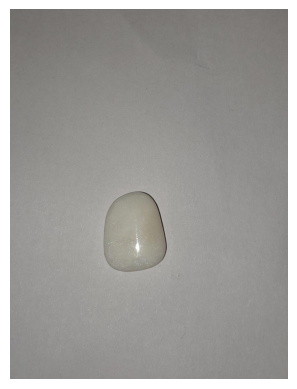

In [28]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axis
plt.show()

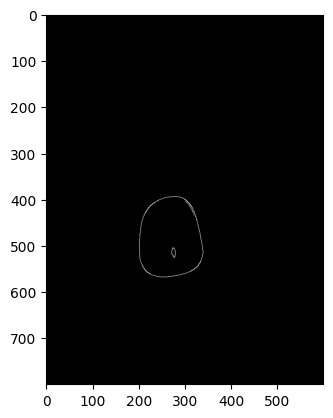

In [29]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.convertScaleAbs(gray)
median_blur = cv2.medianBlur(gray, 5)
plt.imshow(cv2.cvtColor(median_blur, cv2.COLOR_BGR2RGB))

edges = cv2.Canny(median_blur, 100, 200)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))

4


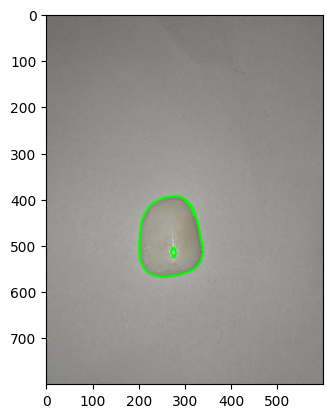

In [23]:
ret, thresh = cv2.threshold(edges, 127, 255, 0)
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Find the biggest contour
print(len(contours))


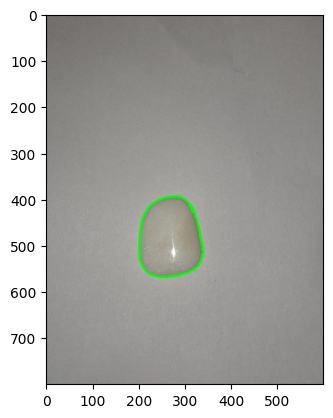

In [31]:
# Initialize variables to store the largest contour and its area
largest_contour = None
max_area = 0

# Iterate through all contours
for contour in contours:
    # Calculate the area of the contour
    area = cv2.contourArea(contour)
    
    # Check if the current contour has a larger area than the maximum area found so far
    if area > max_area:
        max_area = area
        largest_contour = contour

cv2.drawContours(img, [largest_contour], -1, (0,255,0), 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

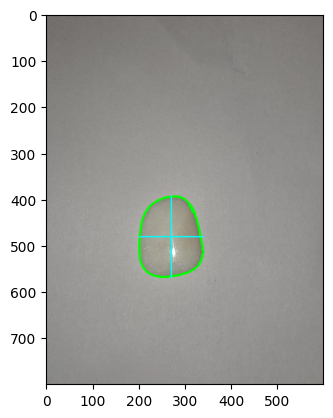

In [32]:
image = img
vertical_line_length_px = None

# Iterate through contours
for contour in [largest_contour]:
    # Find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Compute the center coordinates
    cx = x + w // 2
    cy = y + h // 2
    
    # Compute the total height and width
    total_height = h
    total_width = w
    
    # Draw horizontal and vertical lines through the center
    cv2.line(image, (x, cy), (x + w, cy), (255, 255, 0), 2)  # Horizontal line
    cv2.line(image, (cx, y), (cx, y + h), (255, 255, 0), 2)  # Vertical line
    vertical_line_length_px= h
    
    
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))



In [32]:
# Ask user for the length of the vertical line in mm
vertical_line_length_mm = float(input("Enter the length of the vertical line in mm: "))

Enter the length of the vertical line in mm:  12


In [34]:
import numpy as np
from stl import mesh

# Define the pixel to mm conversion factor
pixel_to_mm = vertical_line_length_mm / vertical_line_length_px  # Example conversion factor (adjust as needed)

points = []
for contour in contours:
    for point in contour:
        x, y = point[0]
        # Apply pixel to mm conversion
        x_mm = x * pixel_to_mm
        y_mm = y * pixel_to_mm
        points.append([x_mm, y_mm, 10])  # assuming a constant depth
    break

# Triangulate points
vertices = np.array(points)
faces = np.arange(len(vertices)).reshape(-1, 3)

# Create the mesh
mesh_data = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
for i, f in enumerate(faces):
    for j in range(3):
        mesh_data.vectors[i][j] = vertices[f[j], :]

# Write to STL file
mesh_data.save('output.stl')


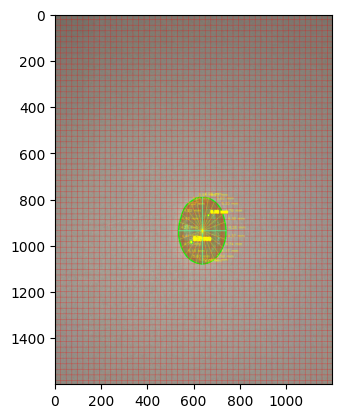

In [29]:
import math

# Calculate conversion factor for pixels to mm

px_to_mm_vertical = vertical_line_length_mm / vertical_line_length_px

# Draw grid
grid_size_mm = 1
grid_color = (0, 0, 255)  # Color of the grid lines
for i in range(0, image.shape[0], int(grid_size_mm / px_to_mm_vertical)):
    cv2.line(image, (0, i), (image.shape[1], i), grid_color, 1)  # Horizontal lines
for j in range(0, image.shape[1], int(grid_size_mm / px_to_mm_vertical)):
    cv2.line(image, (j, 0), (j, image.shape[0]), grid_color, 1)  # Vertical lines


for contour in contours:
    # Find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Compute the center coordinates
    cx = x + w // 2
    cy = y + h // 2
    
    # Draw horizontal and vertical lines through the center
    cv2.line(image, (x, cy), (x + w, cy), (255, 255, 0), 2)  # Horizontal line
    cv2.line(image, (cx, y), (cx, y + h), (255, 255, 0), 2)  # Vertical line
    
    # Draw lines at every 15 degrees
    for angle in range(0, 360, 15):
        # Convert angle to radians
        radians = math.radians(angle)
        # Calculate endpoint coordinates
        end_x = int(cx + w // 2 * math.cos(radians))
        end_y = int(cy + h // 2 * math.sin(radians))
        # Draw line
        cv2.line(image, (cx, cy), (end_x, end_y), (0, 255, 255), 1)  # Lines in cyan
        
        # Calculate length of line in pixels
        length_pixels = math.sqrt((end_x - cx)**2 + (end_y - cy)**2)
        # Convert length from pixels to millimeters
        length_mm = length_pixels * px_to_mm_vertical
        
        # Put text near one end of the line
        text_x = end_x + 10
        text_y = end_y - 10
        cv2.putText(image, f'{length_mm:.2f} mm', (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

